In [24]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from plotnine import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

**Clean the data**

In [2]:
heart = pd.read_csv("/Users/alexandra/Desktop/GSB-544/Labs/Lab7/heart_attack.csv")
heart.dropna(inplace=True)
heart.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


# Part One: Fitting Models
We will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

## Q2KNN

In [3]:
#define x and y
X = heart.drop(columns=['output'])  
y = heart['output'] 

In [4]:
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

knn_model1 = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]  
    
).set_output(transform="pandas")


#find best neighbors
param_knn1 = {
    'knn__n_neighbors': np.arange(1, 100) 
}

#gridsearch
grid_search = GridSearchCV(knn_model1, param_knn1, cv=5, scoring='roc_auc', n_jobs=-1)

# fit data
grid_search.fit(X, y)

best_knn = grid_search.best_estimator_
best_roc_auc = grid_search.best_score_
best_k = grid_search.best_params_['knn__n_neighbors']

# Report the best ROC AUC score from cross-validation
print(f"Best ROC AUC from Cross-Validation: {best_roc_auc:.4f}")
print(f"Best k (number of neighbors): {best_k}")

Best ROC AUC from Cross-Validation: 0.8507
Best k (number of neighbors): 54
Best ROC AUC from Cross-Validation: 0.8507
Best k (number of neighbors): 54


The best ROC AUC from Ccross validation is 0.8507, which means that the model has an 85.07% chance of predicting if the person will have a heart attack. This is pretty good. I got this with a model that had 54 neighbors.

In [5]:
#knn pipeline with best neightbor 54
knn_model2 = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors= 54))]  
    
).set_output(transform="pandas")

knn_model2.fit(X, y)

y_pred_knn2 = knn_model2.predict(X)  

,not at risk,at risk
not at risk,94,33
at risk,24,122


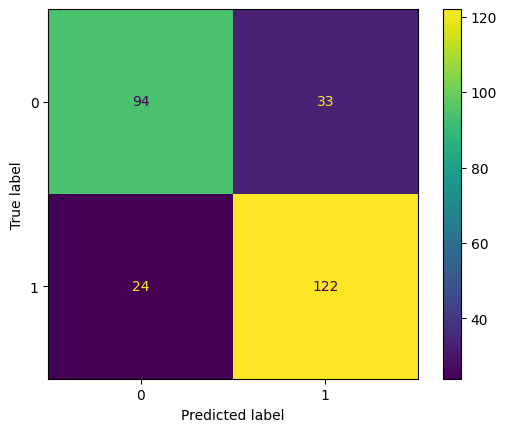

In [6]:
#matrix
cm1= confusion_matrix(y, y_pred_knn2)
cm1
ConfusionMatrixDisplay(cm1).plot()

class_names = ["not at risk", "at risk"]
conf_matrix_knn = pd.DataFrame(cm1, index=class_names, columns=class_names)
conf_matrix_knn

## Q2: Logistic Regression

In [8]:
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

log_model1 = Pipeline(
    [("preprocessing", ct),
    ("log_reg", LogisticRegression())] 
    
).set_output(transform="pandas")


#find best neighbors
param_log1 = {'log_reg__C': [0.01, 0.1, 1, 10, 100]}

#gridsearch
grid_search2 = GridSearchCV(log_model1, param_log1, cv=5, scoring='roc_auc', n_jobs=-1)

# fit data
grid_search2.fit(X, y)
  
#best C
best_C_log1 = grid_search2.best_params_['log_reg__C']
best_roc_auc_log1 = grid_search2.best_score_

print("Log Model:")
print(f"param {best_C_log1}")
print(f"ROC AUC {best_roc_auc_log1}")

Log Model:
param 0.01
ROC AUC 0.8546433244916003
Log Model:
param 0.01
ROC AUC 0.8546433244916003


In [9]:
#log pipeline with best C
best_log_model2 = Pipeline(
    [("preprocessing", ct),
    ("log_reg", LogisticRegression(C=0.01))] 
).set_output(transform="pandas")

best_log_model2.fit(X, y)

y_pred_log = best_log_model2.predict(X)  

,not at risk,at risk
not at risk,88,39
at risk,19,127


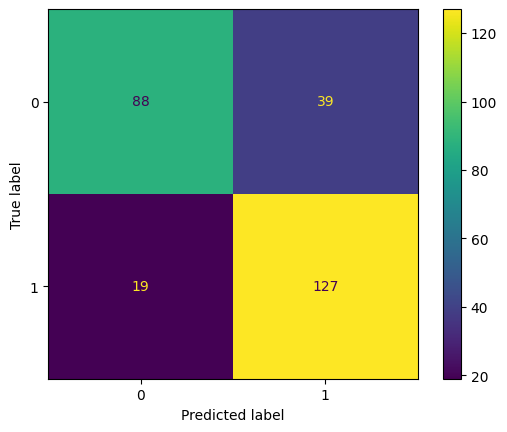

In [10]:
#matrix
cm2= confusion_matrix(y, y_pred_log)
cm2
ConfusionMatrixDisplay(cm2).plot()

class_names = ["not at risk", "at risk"]
conf_matrix_log = pd.DataFrame(cm2, index=class_names, columns=class_names)
conf_matrix_log


## Q3: Decision Tree

In [13]:
#tree model
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

# Decision tree pipeline
dt_model1 = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier())]
).set_output(transform="pandas")

# Parameter grid for GridSearchCV
param_dt =  {'dt__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}


# GridSearchCV setup
grid_search_dt = GridSearchCV(dt_model1, param_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_dt.fit(X, y)


# Retrieve best parameters and score
best_params_dt = grid_search_dt.best_params_

# Output results
print("Decision Tree Results")
print(f"Best Parameters: {best_params_dt}")

Decision Tree Results
Best Parameters: {'dt__min_impurity_decrease': 0.01}
Decision Tree Results
Best Parameters: {'dt__min_impurity_decrease': 0.01}


In [16]:
# #tree model
# ct = ColumnTransformer(
#     [
#         ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
#     ],
#     remainder="passthrough"
# ).set_output(transform="pandas")

# # Decision tree pipeline
# dt_model1 = Pipeline(
#     [("preprocessing", ct),
#      ("dt", DecisionTreeClassifier())]
# ).set_output(transform="pandas")

# # Parameter grid for GridSearchCV
# param_dt = {
#     #'dt__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#     'dt__max_depth': range(1, 11),
#     'dt__min_samples_split': range(2, 11),
#     'dt__min_samples_leaf': range(1, 11),
#     'dt__ccp_alpha': [0.001, 0.01, 0.1, 0.2]
# }


In [14]:
# grid_search_dt.fit(X, y)
# # 

# grid_search_dt = GridSearchCV(dt_model1, param_dt, cv=5, scoring='roc_auc', n_jobs=-1)


# grid_search_dt.fit(X, y)

# # Retrieve best parameters and score
# best_params_dt = grid_search_dt.best_params_

# # Output results
# print("Decision Tree Results")
# print(f"Best Parameters: {best_params_dt}")

In [15]:
# #best tree pipeline
# ct = ColumnTransformer(
#     [
#         ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
#     ],
#     remainder="passthrough"
# ).set_output(transform="pandas")

# # Decision tree pipeline
# dt_best_model = Pipeline(
#     [
#         ("preprocessing", ct),
#         ("dt", DecisionTreeClassifier(ccp_alpha=0.001, max_depth=3, min_samples_leaf=8, min_samples_split=2))
#     ]
# ).set_output(transform="pandas")

# #fit
# dt_best_model.fit(X,y)
# #predict 
# dt_pred = dt_best_model.predict(X)
# #roc auc score
# scores_dt = abs(cross_val_score(dt_best_model, X, y, cv=5, scoring='roc_auc'))
# print(scores_dt.mean())

0.821165694076039
0.821165694076039


In [18]:
#best tree pipeline
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

# Decision tree pipeline
dt_best_model = Pipeline(
    [
        ("preprocessing", ct),
        ("dt", DecisionTreeClassifier(min_impurity_decrease=.001))
    ]
).set_output(transform="pandas")

#fit
dt_best_model.fit(X,y)
#predict 
dt_pred = dt_best_model.predict(X)
#roc auc score
scores_dt = abs(cross_val_score(dt_best_model, X, y, cv=5, scoring='roc_auc'))
print(scores_dt.mean())

0.689000884173298
0.689000884173298


The ROC AUC score of 0.82 indicates that decsion trees are worse at predicting if a patient has a heart attack. 


,not at risk,at risk
not at risk,125,2
at risk,0,146


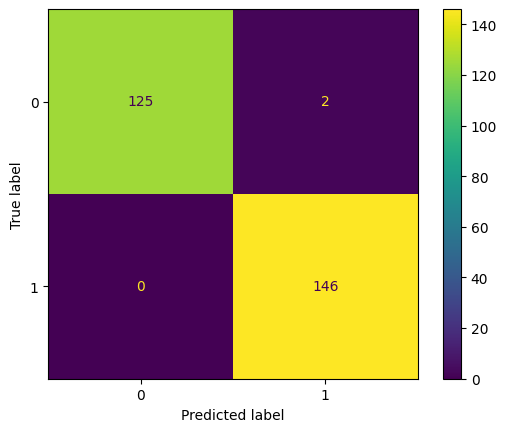

In [22]:
#matrix
cm3= confusion_matrix(y, dt_pred)
cm3
ConfusionMatrixDisplay(cm3).plot()

class_names = ["not at risk", "at risk"]
conf_matrix_log = pd.DataFrame(cm3, index=class_names, columns=class_names)
conf_matrix_log

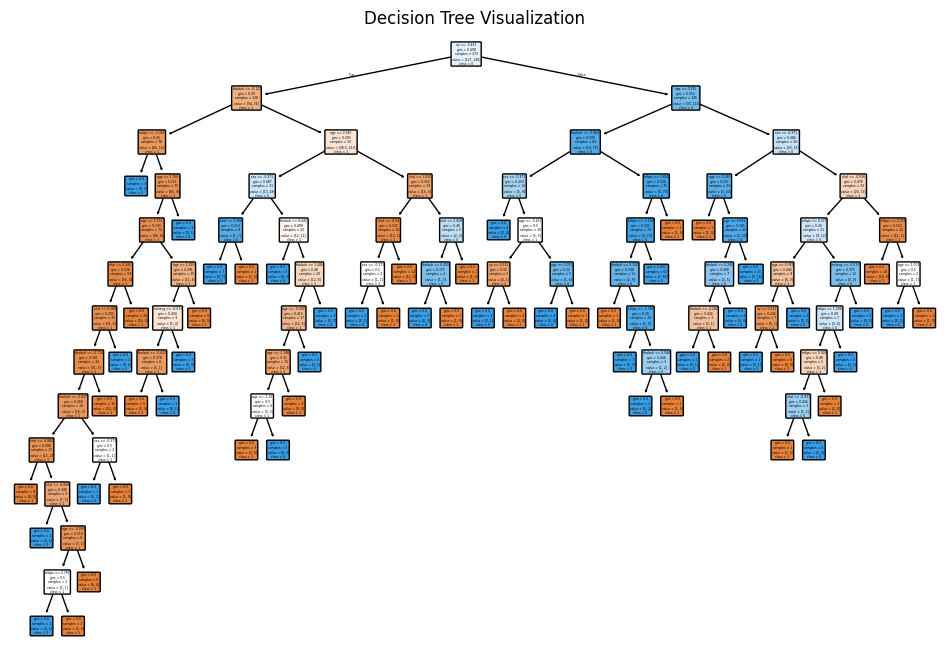

In [25]:
#plot dt with chat gpt help
trained_tree = dt_best_model.named_steps["dt"]

plt.figure(figsize=(12, 8))
plot_tree(
    trained_tree, 
    feature_names=X.columns,  
    class_names=y.unique().astype(str), 
    filled=True, 
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()

# Q4: Interpretation
## Which predictors were most important to predicting heart attack risk?

In [29]:
#find best coeffs for log model
log_reg_model = best_log_model2.named_steps['log_reg']
log_reg_coefficients = log_reg_model.coef_[0]
feature_names = best_log_model2.named_steps['preprocessing'].get_feature_names_out()
log_reg_feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': log_reg_coefficients}).sort_values('Coefficient', ascending = False)
log_reg_feature_importance

,Feature,Coefficient
2,standardize__cp,0.302322
6,standardize__thalach,0.280505
5,standardize__restecg,0.086628
4,standardize__chol,-0.054690
3,standardize__trtbps,-0.097634
0,standardize__age,-0.136729
1,standardize__sex,-0.252337


In [34]:
#with chat gpr help to get coeff for dt
# Extract the trained DecisionTreeClassifier from the pipeline
trained_tree = dt_best_model.named_steps["dt"]

# Get feature names from the pipeline's preprocessing step
feature_names = dt_best_model.named_steps["preprocessing"].get_feature_names_out()

# Get the feature importances
importances = trained_tree.feature_importances_

# Combine feature names with their importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display the top features
print("Feature Importance Rankings:")
print(importance_df)


Feature Importance Rankings:
                Feature  Importance
2       standardize__cp    0.288770
0      standardize__age    0.212164
6  standardize__thalach    0.185057
4     standardize__chol    0.119872
3   standardize__trtbps    0.093517
1      standardize__sex    0.071452
5  standardize__restecg    0.029168
Feature Importance Rankings:
                Feature  Importance
2       standardize__cp    0.288770
0      standardize__age    0.212164
6  standardize__thalach    0.185057
4     standardize__chol    0.119872
3   standardize__trtbps    0.093517
1      standardize__sex    0.071452
5  standardize__restecg    0.029168


The variables I found to be most impactful was the type of chest pain for both models and age for trees and max heart rate reached.

# ROC CURVE

In [38]:
#PLot ROC curve: used chat gpt 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 3)

probs_knn = knn_model2.predict_proba(X_test)[:, 1]
probs_log_reg = best_log_model2 .predict_proba(X_test)[:, 1]
probs_decision_tree = dt_best_model.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, probs_knn)
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, probs_log_reg)
fpr_decision_tree, tpr_decision_tree, thresholds_decision_tree = roc_curve(y_test, probs_decision_tree)

auc_knn = auc(fpr_knn, tpr_knn)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)

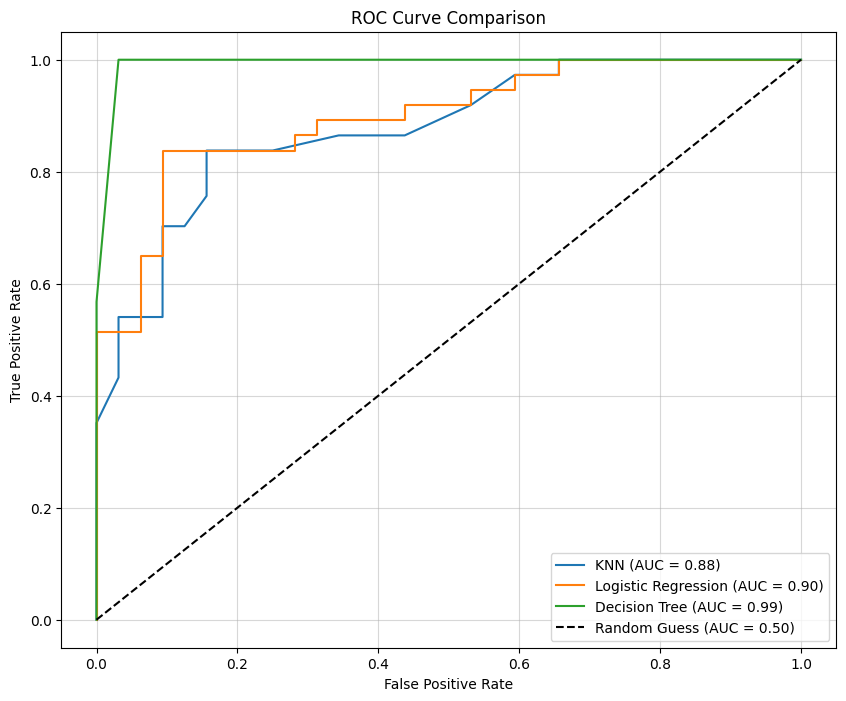

In [39]:
#chat gpt helped me create this plot
plt.figure(figsize=(10, 8))

# KNN ROC Curve
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')

# Logistic Regression ROC Curve
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.2f})')

# Decision Tree ROC Curve
plt.plot(fpr_decision_tree, tpr_decision_tree, label=f'Decision Tree (AUC = {auc_decision_tree:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)

# Show the plot
# plt.show()

# Part Two: Metrics

In [40]:
#chat gpt helpedme write a function 
from sklearn.metrics import recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
import numpy as np

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Compute metrics for KNN
knn_cv_recall = cross_val_score(knn_model2, X, y, cv=5, scoring='recall').mean()
knn_cv_precision = cross_val_score(knn_model2, X, y, cv=5, scoring='precision').mean()
knn_cv_specificity = cross_val_score(knn_model2, X, y, cv=5, scoring=specificity_scorer).mean()

# Compute metrics for Logistic Regression
log_cv_recall = cross_val_score(best_log_model2, X, y, cv=5, scoring='recall').mean()
log_cv_precision = cross_val_score(best_log_model2, X, y, cv=5, scoring='precision').mean()
log_cv_specificity = cross_val_score(best_log_model2, X, y, cv=5, scoring=specificity_scorer).mean()

# Compute metrics for Decision Tree
dt_cv_recall = cross_val_score(dt_best_model, X, y, cv=5, scoring='recall').mean()
dt_cv_precision = cross_val_score(dt_best_model, X, y, cv=5, scoring='precision').mean()
dt_cv_specificity = cross_val_score(dt_best_model, X, y, cv=5, scoring=specificity_scorer).mean()

# Display results
print("Model Performance Metrics (Cross-Validated):")
print("\nKNN:")
print(f"Recall (Sensitivity): {knn_cv_recall:.2f}")
print(f"Precision: {knn_cv_precision:.2f}")
print(f"Specificity: {knn_cv_specificity:.2f}")

print("\nLogistic Regression:")
print(f"Recall (Sensitivity): {log_cv_recall:.2f}")
print(f"Precision: {log_cv_precision:.2f}")
print(f"Specificity: {log_cv_specificity:.2f}")

print("\nDecision Tree:")
print(f"Recall (Sensitivity): {dt_cv_recall:.2f}")
print(f"Precision: {dt_cv_precision:.2f}")
print(f"Specificity: {dt_cv_specificity:.2f}")


Model Performance Metrics (Cross-Validated):

KNN:
Recall (Sensitivity): 0.82
Precision: 0.77
Specificity: 0.72

Logistic Regression:
Recall (Sensitivity): 0.87
Precision: 0.74
Specificity: 0.65

Decision Tree:
Recall (Sensitivity): 0.68
Precision: 0.73
Specificity: 0.68
Model Performance Metrics (Cross-Validated):

KNN:
Recall (Sensitivity): 0.82
Precision: 0.77
Specificity: 0.72

Logistic Regression:
Recall (Sensitivity): 0.87
Precision: 0.74
Specificity: 0.65

Decision Tree:
Recall (Sensitivity): 0.68
Precision: 0.73
Specificity: 0.68


The logistic regression model has the highest recall compared to the other models. However my decsion tree model had the best precsion which means it had the least false positives. In thise application that is really important. 

# Part Three: Discussion

### Q1 The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack

I would want to look at recall because thus metric looks at the proportion of people that true positives agaisnt predicted positives. We want this number to be high because, the hospital is penalized if a patient is  "positive" but deemed fine or low risk. i would use my logistic model because it had the highest recall. 

### Q2 The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk

I would use precsion because I want to be sure that the people that are getting bed space are actaully in need of a bed. I would use my logistic model because it had a precsion score of .87 which means that 87% of the time the predictions are correct. 

### Q3 The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

We want to understand this cuase and effect relationship so I think it is important to have precise answers and data to look at. I would say something similar to Q2. This would help when explaining and interpreting data. Specifically it would be good to look individualy at variables. 

### Q4 The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

I think this question is copmplex and has two parts. The doctors need to be precise in their digagnosis, and give an accurate prediction. But Doctors also need a specific model to ensure that the diagnosis they give to the patient is correct. Espcially in hospoital settings it is important to be accurate in diganisis. I would likeley use the logistic model again here. However the KNN model

# Part Four: Validation

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [43]:
ha_validation = pd.read_csv("/Users/alexandra/Desktop/GSB-544/Labs/Lab7/heart_attack.csv")

In [ ]:
ha_validation['sex'] = ha_validation['sex'].astype('category')
ha_validation['cp'] = ha_validation['cp'].astype('category')
ha_validation['restecg'] = ha_validation['restecg'].astype('category')
ha_validation['output'] = ha_validation['output'].astype('category')

In [49]:
X_val=ha_validation.drop("output", axis=1)
y_val= ha_validation["output"]

In [50]:
#knn validation 
knn_preds = knn_model2.predict(X_val)
knn_probs = knn_model2.predict_proba(X_val)[:, 1]

knn_confusion = confusion_matrix(y_val, knn_preds)
knn_roc_auc = roc_auc_score(y_val, knn_probs)
knn_precision = precision_score(y_val, knn_preds)
knn_recall = recall_score(y_val, knn_preds)

print("Confusion Matrix:\n", knn_confusion)
print("ROC AUC:", knn_roc_auc)
print("Precision:", knn_precision)
print("Recall:", knn_recall)

Confusion Matrix:
 [[ 94  33]
 [ 24 122]]
ROC AUC: 0.8584025455722144
Precision: 0.7870967741935484
Recall: 0.8356164383561644
Confusion Matrix:
 [[ 94  33]
 [ 24 122]]
ROC AUC: 0.8584025455722144
Precision: 0.7870967741935484
Recall: 0.8356164383561644


In [52]:
#logistic reg

log_preds = best_log_model2.predict(X_val)
log_probs = best_log_model2.predict_proba(X_val)[:, 1]

log_confusion = confusion_matrix(y_val, log_preds)
log_roc_auc = roc_auc_score(y_val, log_probs)
log_precision = precision_score(y_val, log_preds)
log_recall = recall_score(y_val, log_preds)

print("Confusion Matrix:\n", log_confusion)
print("ROC AUC:", log_roc_auc)
print("Precision:", log_precision)
print("Recall:",log_recall)

Confusion Matrix:
 [[ 88  39]
 [ 19 127]]
ROC AUC: 0.8642541257685254
Precision: 0.7650602409638554
Recall: 0.8698630136986302
Confusion Matrix:
 [[ 88  39]
 [ 19 127]]
ROC AUC: 0.8642541257685254
Precision: 0.7650602409638554
Recall: 0.8698630136986302


In [56]:
#decsion tree

dt_preds = dt_best_model.predict(X_val)
dt_probs = dt_best_model.predict_proba(X_val)[:, 1]

dt_confusion = confusion_matrix(y_val, dt_preds)
dt_roc_auc = roc_auc_score(y_val, dt_probs)
dt_precision = precision_score(y_val, dt_preds)
dt_recall = recall_score(y_val, dt_preds)

print("Confusion Matrix:\n", dt_confusion)
print("ROC AUC:", dt_roc_auc)
print("Precision:", dt_precision)
print("Recall:",dt_recall)

Confusion Matrix:
 [[125   2]
 [  0 146]]
ROC AUC: 0.9967101715025348
Precision: 0.9864864864864865
Recall: 1.0
Confusion Matrix:
 [[125   2]
 [  0 146]]
ROC AUC: 0.9967101715025348
Precision: 0.9864864864864865
Recall: 1.0


# part 5